Figures for Section 1.4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
# preprocess data
wine = [i.strip().split() for i in open("../../data/wine.dat.rtf").readlines()]
# remove entries with '\\'
wine_cleaned = [m for m in wine if '\\' not in ' '.join(m)]

# slice the data, remove the first and last entries
wine_df = pd.DataFrame(wine_cleaned[1:-1])

# change datatype from str to int
wine_df = wine_df.astype({0:'int'})
#wine_df.head()

Figure 1.10

Time series plots of the red wine sales in Australia from January 1980 to October 1991
(left) and its log transformation with yearly mean estimates (right).

In [21]:
# create time stamps
times = np.arange(np.datetime64('1980-01'),
                  np.datetime64('1991-10'))

# log-transformation
wine_df['log'] = np.log(wine_df[0])
# create a date column
wine_df['date'] = pd.date_range('1980-01', '1991-10',freq='M')

,0,log,date
0,675,6.514713,1980-01-31
1,703,6.555357,1980-02-29
2,887,6.787845,1980-03-31
3,1139,7.037906,1980-04-30
4,1077,6.981935,1980-05-31


In [25]:
# calculate the yearly average from monthly day for log-transformed data
# reset index, generate a new dataframe
wine_year = wine_df.groupby(pd.PeriodIndex(wine_df['date'], freq="Y"))['log'].mean().reset_index()
# repeat values with freq=12
newdf = pd.DataFrame(np.repeat(wine_year.values, 12, axis=0))
# column names
newdf.columns = ['year','average']

# select the previous 141 data, assign to 'yearly_average'
wine_df['yearly_average'] = newdf['average'][:141]
wine_df.head()

,0,log,date,yearly_average
0,675,6.514713,1980-01-31,6.844599
1,703,6.555357,1980-02-29,6.844599
2,887,6.787845,1980-03-31,6.844599
3,1139,7.037906,1980-04-30,6.844599
4,1077,6.981935,1980-05-31,6.844599


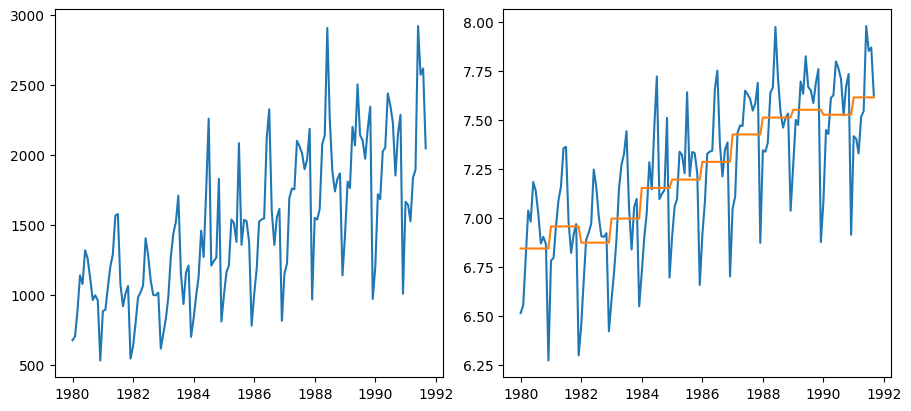

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9,4),constrained_layout = True)
axs[0].plot(times, wine_df[0])
# plot log-transferred data
axs[1].plot(times, wine_df['log'])
# plot yearly average data
axs[1].plot(times, wine_df['yearly_average'])
plt.show()

Figure 1.11

The detrended log series (left), the estimated seasonal component (center) and the corresponding
residuals series (right) of the Australian red wine sales data.

In [57]:
# calcualted estimated seasonal components
# extract yearly average values
m = wine_df['yearly_average'].unique()
N,d = 12,12
w_log = wine_df['log']

# store estimated seasonality
# intialize as an array
s = np.zeros(d)    
for k in range(d):
    j=0
    sN = 0
    while k+j*d < len(w_log):
        # relabel observations
        i = k + j*d
        sN = sN + (w_log[i]-m[j])
        j = j+1
    s[k] = 1/N * sN

# the sum of s should be 0
# np.sum(s)

# create a new column for estimated seasonal components
wine_df = wine_df.assign(est_s=s[np.arange(len(wine_df)) % N])

# calcualte residuals
wine_df['res'] = wine_df['log']-wine_df['yearly_average'] - wine_df['est_s']

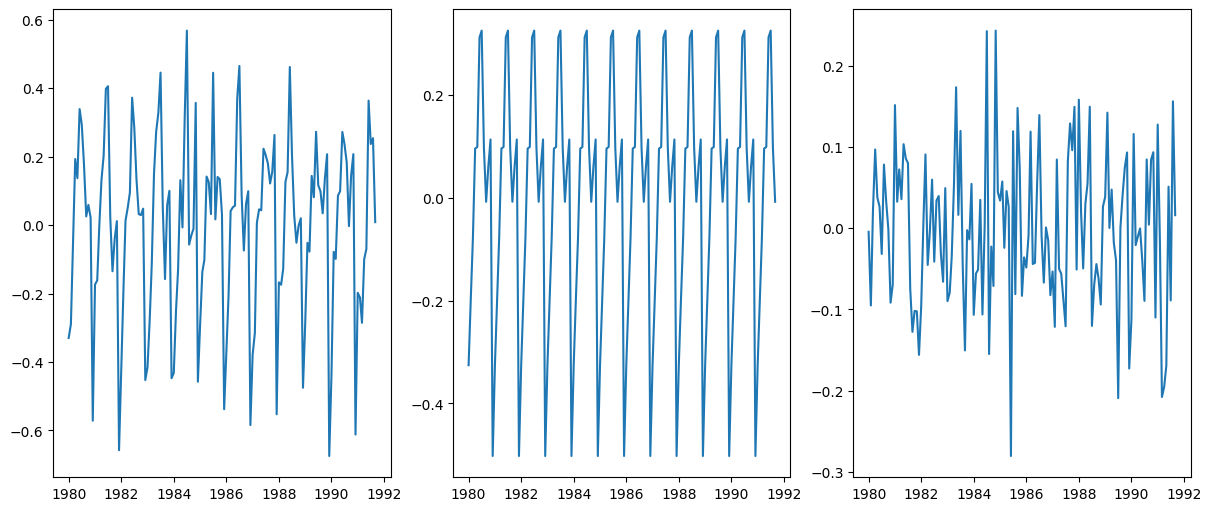

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(12,5),constrained_layout = True)
axs[0].plot(times, wine_df['log']-wine_df['yearly_average'])
axs[1].plot(times, wine_df['est_s'])
axs[2].plot(times, wine_df['res'])

Figure 1.12

The differenced observed series $\nabla_{12}x_t$ (left), $\nabla x_t$ (middle) and $\nabla\nabla_{12} x_t = \nabla_{12}\nabla x_t$ (right)
for the Australian red wine sales data.

In [55]:
# create a lag-difference
def lagDiff(data,d):
    lagdiff = list()
    for i in range(d, len(data)):
        v = data[i] - data[i-d]
        lagdiff.append(v)
    
    return lagdiff

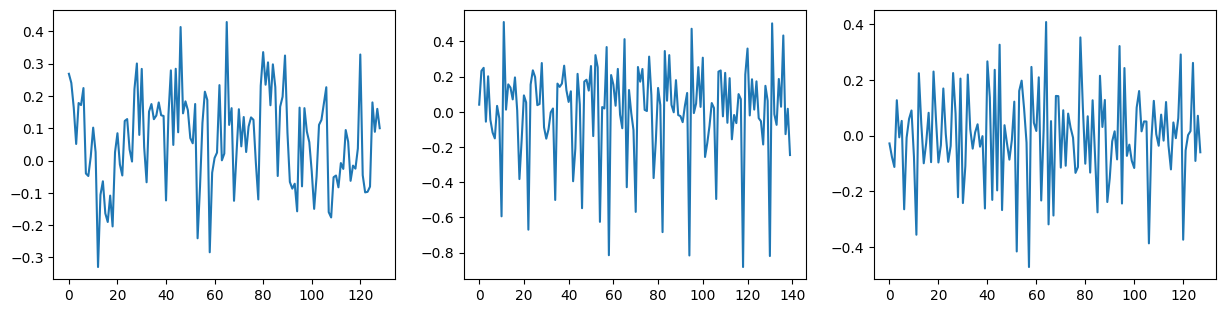

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15,3.5))

lag12 = lagDiff(w_log, 12)
axs[0].plot(lag12)

df1 = np.diff(w_log)
axs[1].plot(df1)

df2 = np.diff(lag12)
axs[2].plot(df2)

Reference:

1. https://matplotlib.org/stable/api/dates_api.html
2. https://stackoverflow.com/questions/65471540/get-monthly-average-in-pandas
3. https://stackoverflow.com/questions/50788508/how-can-i-replicate-rows-of-a-pandas-dataframe
4. https://stackoverflow.com/questions/47255885/how-do-i-add-a-column-to-a-dataframe-with-a-repeating-series-of-values
5. https://machinelearningmastery.com/difference-time-series-dataset-python/